# sktime's functionalities

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.arima import AutoARIMA, ARIMA
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error, MeanAbsoluteScaledError, MedianAbsolutePercentageError, median_absolute_percentage_error, make_forecasting_scorer, MeanAbsolutePercentageError
from sktime.forecasting.compose import (
    EnsembleForecaster,
    MultiplexForecaster,
    TransformedTargetForecaster,
    make_reduction,
)
from sktime.forecasting.model_selection import ForecastingGridSearchCV, SlidingWindowSplitter, ExpandingWindowSplitter, ForecastingGridSearchCV, ForecastingRandomizedSearchCV
from sktime.utils.plotting import plot_series
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
sns.set(rc={'figure.figsize':(12,6)})

### Importing data

In [4]:
df = sm.datasets.macrodata.load_pandas()['data']

In [5]:
df.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


### Data overview

Dataset contains USA quarterly macroeconomic data between 1959 and 2009. 

**Target variable - `realgdp`**

In [6]:
df['q_date'] = df.apply(lambda x: str(int(x['year'])) + "-" + 'Q'+ str(int(x['quarter'])), axis=1)
df['date'] = pd.PeriodIndex(df['q_date'], freq='Q').to_timestamp()

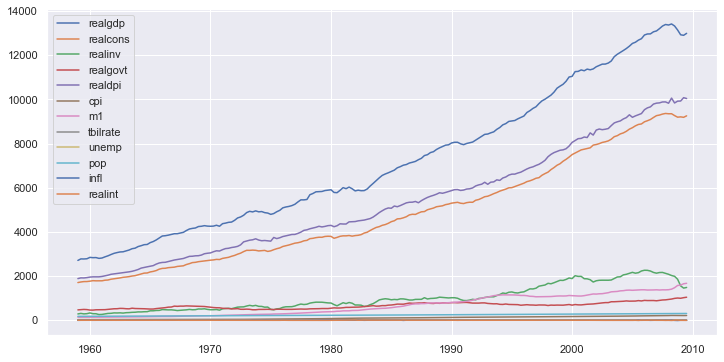

In [7]:
for val in df.columns[2:14]:
    plt.plot(df.date, df[val], label = val)
plt.legend()

In [8]:
df = df.set_index('date').to_period("Q")
df.index

PeriodIndex(['1959Q1', '1959Q2', '1959Q3', '1959Q4', '1960Q1', '1960Q2',
             '1960Q3', '1960Q4', '1961Q1', '1961Q2',
             ...
             '2007Q2', '2007Q3', '2007Q4', '2008Q1', '2008Q2', '2008Q3',
             '2008Q4', '2009Q1', '2009Q2', '2009Q3'],
            dtype='period[Q-DEC]', name='date', length=203)

In [9]:
df.index

PeriodIndex(['1959Q1', '1959Q2', '1959Q3', '1959Q4', '1960Q1', '1960Q2',
             '1960Q3', '1960Q4', '1961Q1', '1961Q2',
             ...
             '2007Q2', '2007Q3', '2007Q4', '2008Q1', '2008Q2', '2008Q3',
             '2008Q4', '2009Q1', '2009Q2', '2009Q3'],
            dtype='period[Q-DEC]', name='date', length=203)

## 1. Unified API

### Basic forecasters interface

In [10]:
y = df['realgdp']
y_train, y_test = temporal_train_test_split(y, test_size=30)

In [11]:
forecaster = NaiveForecaster()
forecaster.fit(y_train)
y_pred = forecaster.predict(fh=1)

In [12]:
y_pred

2002Q2    11477.868
Freq: Q-DEC, dtype: float64

### Forecasting horizons

In [13]:
fh_abs = ForecastingHorizon(y_test.index, is_relative=False) #specific periods
fh_abs

ForecastingHorizon(['2002Q2', '2002Q3', '2002Q4', '2003Q1', '2003Q2', '2003Q3',
             '2003Q4', '2004Q1', '2004Q2', '2004Q3', '2004Q4', '2005Q1',
             '2005Q2', '2005Q3', '2005Q4', '2006Q1', '2006Q2', '2006Q3',
             '2006Q4', '2007Q1', '2007Q2', '2007Q3', '2007Q4', '2008Q1',
             '2008Q2', '2008Q3', '2008Q4', '2009Q1', '2009Q2', '2009Q3'],
            dtype='period[Q-DEC]', name='date', is_relative=False)

In [14]:
cutoff = pd.Period("2002-01-01", freq="Q") #last point of the training series
fh_rel = fh_abs.to_relative(cutoff) #relative values
fh_rel

ForecastingHorizon([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
           dtype='int64', is_relative=True)

In [15]:
#negative steps for in-sample forecasts
fh_abs.to_relative(pd.Period("2004-04-01", freq="Q"))

ForecastingHorizon([-8, -7, -6, -5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8,
             9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21],
           dtype='int64', is_relative=True)

In [16]:
#first forecast - 12th period after the last training data point
fh_abs.to_relative(pd.Period("1999-04-01", freq="Q"))

ForecastingHorizon([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
            29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41],
           dtype='int64', is_relative=True)

### Univariate time series

MASE: 3.283


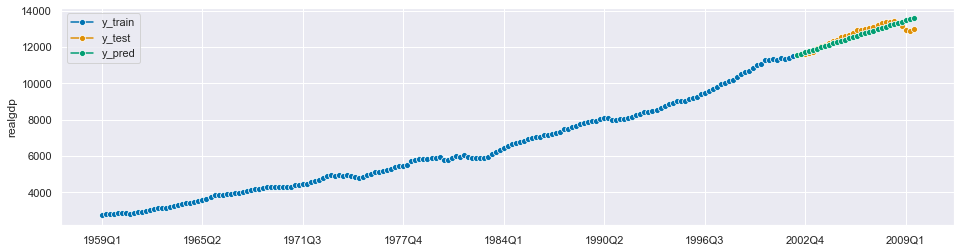

In [17]:
y = df['realgdp']
y_train, y_test = temporal_train_test_split(y, test_size=30)

forecaster = AutoARIMA()
forecaster.fit(y_train)
y_pred = forecaster.predict(fh=fh_abs)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print(f"MASE: {round(mean_absolute_scaled_error(y_true=y_test, y_pred=y_pred, y_train=y_train), 3)}")

### Multivariate time series
Forecasting with extra regressors

MASE: 2.322


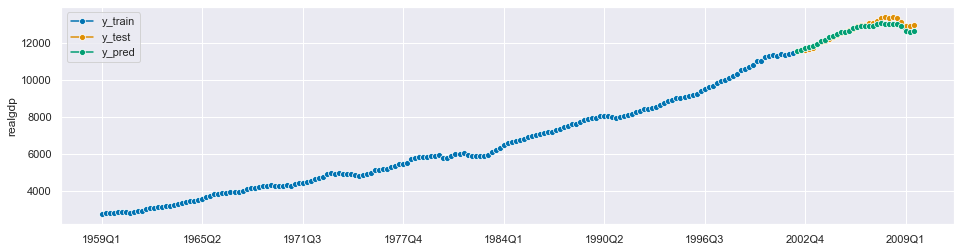

In [18]:
y = df['realgdp']
X = df[['realinv']] #could be more features
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, fh=fh_abs)

forecaster = AutoARIMA()
forecaster.fit(y_train, X_train)
y_pred = forecaster.predict(X=X_test, fh=fh_abs)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print(f"MASE: {round(mean_absolute_scaled_error(y_true=y_test, y_pred=y_pred, y_train=y_train), 3)}")

### Updating a forecaster

In [19]:
y_old_data = y_train[:-4]
forecaster = AutoARIMA()
forecaster.fit(y_old_data)
y_old_pred = forecaster.predict(fh_rel)

In [20]:
#updating the model with new data (full year) and generating predictions for the next period
y_new_data = y_train[-4:]
forecaster.update(y_new_data)
y_new_pred = forecaster.predict(fh_rel)

## 2. Reducing a forecasting task to a regression problem

MASE: 4.712


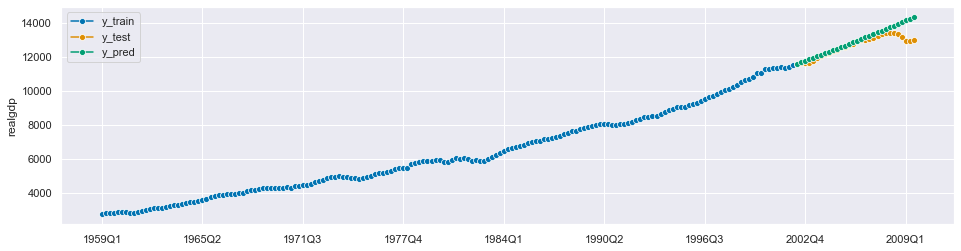

In [21]:
regressor = LinearRegression()
forecaster = make_reduction(estimator=regressor, strategy='recursive',window_length=2)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh_abs)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print(f"MASE: {round(mean_absolute_scaled_error(y_true=y_test, y_pred=y_pred, y_train=y_train), 3)}")

## 3. Evaluation of forecasting models

### Performance metrics

12.174663216304166

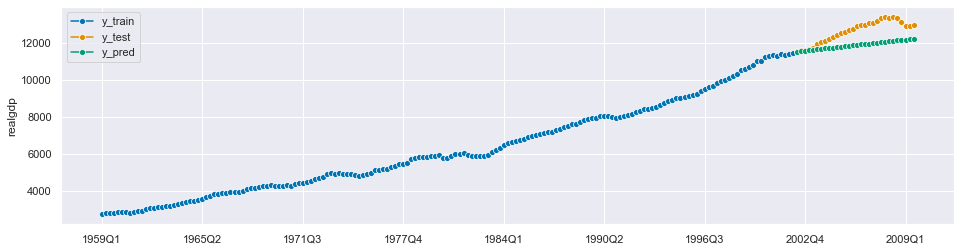

In [22]:
y = df['realgdp']
y_train, y_test = temporal_train_test_split(y, test_size=30)
fh_abs = ForecastingHorizon(y_test.index, is_relative=False)

forecaster = ThetaForecaster()
forecaster.fit(y_train)
y_pred = forecaster.predict(fh=fh_abs)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_scaled_error(y_true=y_test, y_pred=y_pred, y_train=y_train)

In [23]:
median_absolute_percentage_error(y_test, y_pred)

0.061994002943796644

In [24]:
mdape = MedianAbsolutePercentageError()
mdape(y_true=y_test, y_pred=y_pred)

0.061994002943796644

In [25]:
mdape.greater_is_better

False

In [26]:
#custom mape calculated on predictions with a ceil
def custom_mape(y: np.array, y_hat: np.array, multioutput: str):
    if multioutput == 'uniform_average':
        return np.mean(np.abs((y - np.ceil(y_hat)) / y))
    elif multioutput == 'raw_values':
        return np.abs((y - np.ceil(y_hat)) / y)
    else:
        raise ValueError("multioutput not specified correctly - pick `raw_values` or `uniform_average`")

In [27]:
mape_changed = make_forecasting_scorer(func=custom_mape, multioutput = 'uniform_average')
mape_changed(y_test, y_pred)

0.05751249071487726

In [28]:
mape_changed = make_forecasting_scorer(func=custom_mape, multioutput = 'raw_values')
mape_changed(y_test, y_pred)

date
2002Q2    0.001020
2002Q3    0.003918
2002Q4    0.002054
2003Q1    0.004020
2003Q2    0.009772
2003Q3    0.024085
2003Q4    0.030792
2004Q1    0.035508
2004Q2    0.040349
2004Q3    0.045396
2004Q4    0.051593
2005Q1    0.059048
2005Q2    0.061135
2005Q3    0.066320
2005Q4    0.069160
2006Q1    0.079355
2006Q2    0.080807
2006Q3    0.079124
2006Q4    0.083968
2007Q1    0.084879
2007Q2    0.090198
2007Q3    0.096397
2007Q4    0.099337
2008Q1    0.095899
2008Q2    0.097297
2008Q3    0.089354
2008Q4    0.074869
2009Q1    0.057438
2009Q2    0.053831
2009Q3    0.058454
Freq: Q-DEC, dtype: float64

### Time-based cross-validation

In [29]:
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import ExpandingWindowSplitter

- **Expanding Window**

In [30]:
forecaster = AutoARIMA(sp=4)
cv = ExpandingWindowSplitter(step_length=30, fh=list(range(1,31)), initial_window=40)
df = evaluate(forecaster=forecaster, y=y, cv=cv, strategy="update", return_data=True, scoring = MeanAbsolutePercentageError(symmetric=True))

In [31]:
df

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred
0,0.026765,0.920559,0.005283,40,1968Q4,date 1959Q1 2710.349 1959Q2 2778.801 195...,date 1969Q1 4244.100 1969Q2 4256.460 196...,1969Q1 4211.384583 1969Q2 4248.007673 19...
1,0.022689,1.321082,0.005694,70,1976Q2,date 1959Q1 2710.349 1959Q2 2778.801 195...,date 1976Q3 5154.072 1976Q4 5191.499 197...,1976Q3 5183.195991 1976Q4 5222.693347 19...
2,0.061730,0.894143,0.005019,100,1983Q4,date 1959Q1 2710.349 1959Q2 2778.801 195...,date 1984Q1 6448.264 1984Q2 6559.594 198...,1984Q1 6385.598862 1984Q2 6428.366855 19...
3,0.051239,0.934987,0.005561,130,1991Q2,date 1959Q1 2710.349 1959Q2 2778.801 195...,date 1991Q3 8037.538 1991Q4 8069.046 1...,1991Q3 8048.706257 1991Q4 8090.890623 19...
4,0.009264,2.990517,0.004181,160,1998Q4,date 1959Q1 2710.349 1959Q2 2778.801 1...,date 1999Q1 10601.179 1999Q2 10684.049 1...,1999Q1 10623.174768 1999Q2 10727.402351 ...


Average MAPE with Expanding Window: 0.034


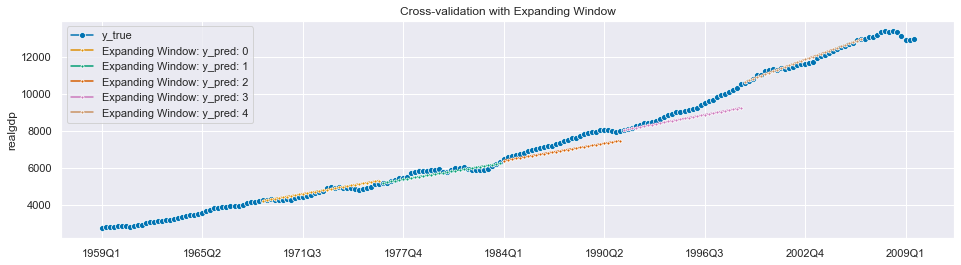

In [32]:
fig, ax = plot_series(
    y,
    df["y_pred"].iloc[0],
    df["y_pred"].iloc[1],
    df["y_pred"].iloc[2],
    df["y_pred"].iloc[3],
    df["y_pred"].iloc[4],
    markers=["o", *["."]*5],
    labels=["y_true"] + [f"Expanding Window: y_pred: {x}" for x in range(5)]
)
print(f"Average MAPE with Expanding Window: {round(df['test_MeanAbsolutePercentageError'].mean(), 3)}")
plt.title('Cross-validation with Expanding Window');

- **Sliding Window**

In [33]:
forecaster = AutoARIMA(sp=4)
cv = SlidingWindowSplitter(step_length=30, fh=list(range(1,31)), initial_window=40)
df = evaluate(forecaster=forecaster, y=y, cv=cv, strategy="update", return_data=True, scoring = MeanAbsolutePercentageError(symmetric=True))

In [34]:
df

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred
0,0.026765,0.947972,0.006298,40,1968Q4,date 1959Q1 2710.349 1959Q2 2778.801 195...,date 1969Q1 4244.100 1969Q2 4256.460 196...,1969Q1 4211.384583 1969Q2 4248.007673 19...
1,0.031793,0.728204,0.005427,10,1976Q2,date 1974Q1 4909.617 1974Q2 4922.188 197...,date 1976Q3 5154.072 1976Q4 5191.499 197...,1976Q3 5178.306143 1976Q4 5227.665286 19...
2,0.017501,0.741936,0.005209,10,1983Q4,date 1981Q3 6030.184 1981Q4 5955.062 198...,date 1984Q1 6448.264 1984Q2 6559.594 198...,1984Q1 6386.849 1984Q2 6448.124 1984Q3 ...
3,0.011277,0.702613,0.005053,10,1991Q2,date 1989Q1 7806.603 1989Q2 7865.016 198...,date 1991Q3 8037.538 1991Q4 8069.046 1...,1991Q3 8080.539 1991Q4 8157.256 1992Q1...
4,0.050590,5.830579,0.004300,10,1998Q4,date 1996Q3 9488.879 1996Q4 9592.458 1...,date 1999Q1 10601.179 1999Q2 10684.049 1...,1999Q1 10749.932211 1999Q2 10780.149868 ...


Average MAPE with Sliding Window: 0.028


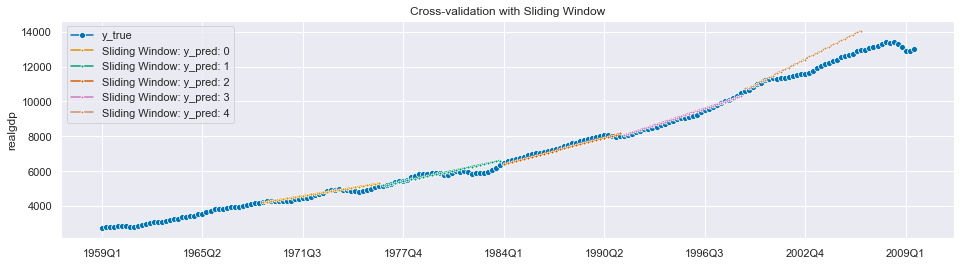

In [35]:
fig, ax = plot_series(
    y,
    df["y_pred"].iloc[0],
    df["y_pred"].iloc[1],
    df["y_pred"].iloc[2],
    df["y_pred"].iloc[3],
    df["y_pred"].iloc[4],
    markers=["o", *["."]*5],
    labels=["y_true"] + [f"Sliding Window: y_pred: {x}" for x in range(5)],
)
ax.legend()
print(f"Average MAPE with Sliding Window: {round(df['test_MeanAbsolutePercentageError'].mean(), 3)}")
plt.title('Cross-validation with Sliding Window');

### Tuning

In [36]:
from sktime.forecasting.model_selection import ForecastingGridSearchCV, ForecastingRandomizedSearchCV

- **Grid Search with statistical model**

In [37]:
forecaster = ARIMA()
param_grid = {"order": [(1, 0, 0), (1, 0, 1), (0, 0, 1)], 'with_intercept': [True, False]}

In [38]:
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.8), window_length=20)
gscv = ForecastingGridSearchCV(forecaster, strategy="refit", cv=cv, param_grid=param_grid)

In [39]:
gscv.fit(y_train)

ForecastingGridSearchCV(cv=SlidingWindowSplitter(initial_window=138, window_length=20),
                        forecaster=ARIMA(),
                        param_grid={'order': [(1, 0, 0), (1, 0, 1), (0, 0, 1)],
                                    'with_intercept': [True, False]})

In [40]:
y_pred = gscv.predict(fh_abs)

In [41]:
gscv.best_params_

{'order': (1, 0, 1), 'with_intercept': False}

In [42]:
gscv.best_score_

0.008168138378736997

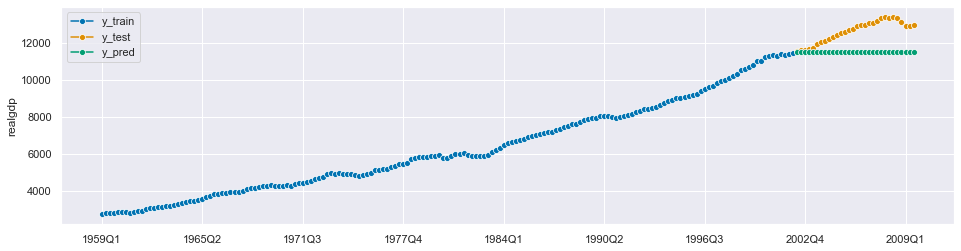

In [43]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

In [44]:
gscv.get_params()

{'cv': SlidingWindowSplitter(initial_window=138, window_length=20),
 'forecaster__maxiter': 50,
 'forecaster__method': 'lbfgs',
 'forecaster__order': (1, 0, 0),
 'forecaster__out_of_sample_size': 0,
 'forecaster__scoring': 'mse',
 'forecaster__scoring_args': None,
 'forecaster__seasonal_order': (0, 0, 0, 0),
 'forecaster__start_params': None,
 'forecaster__suppress_warnings': False,
 'forecaster__trend': None,
 'forecaster__with_intercept': True,
 'forecaster': ARIMA(),
 'n_jobs': None,
 'param_grid': {'order': [(1, 0, 0), (1, 0, 1), (0, 0, 1)],
  'with_intercept': [True, False]},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'scoring': None,
 'strategy': 'refit',
 'verbose': 0}

- **Randomized Search with scikit-learn model**

In [45]:
regressor = LinearRegression()
forecaster = make_reduction(regressor, strategy="recursive")
param_distributions = {"window_length": list(range(2, 21))}

In [46]:
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.8), window_length=20)
rscv = ForecastingRandomizedSearchCV(forecaster, strategy="refit", cv=cv, 
                                     param_distributions=param_distributions, n_iter = 5, random_state=42)

In [47]:
rscv.fit(y_train)
y_pred = rscv.predict(fh_abs)

In [48]:
rscv.best_params_

{'window_length': 2}

In [49]:
rscv.best_score_

0.004633909339134883

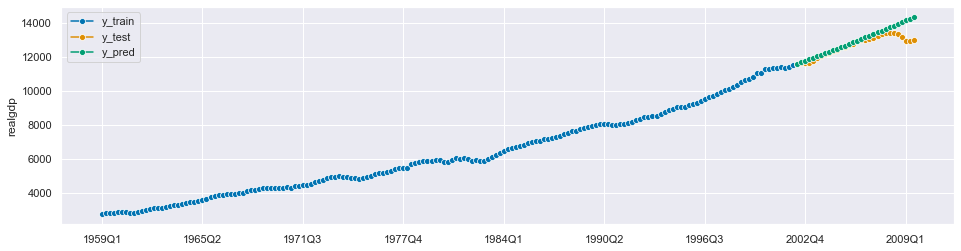

In [50]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

- **Tuning nested parameters**

Random Forest Regressor

In [51]:
from sklearn.ensemble import RandomForestRegressor

In [52]:
regressor = RandomForestRegressor(n_estimators=20)
forecaster = make_reduction(regressor, scitype="tabular-regressor", strategy="recursive")

In [53]:
forecaster.get_params()

{'estimator__bootstrap': True,
 'estimator__ccp_alpha': 0.0,
 'estimator__criterion': 'mse',
 'estimator__max_depth': None,
 'estimator__max_features': 'auto',
 'estimator__max_leaf_nodes': None,
 'estimator__max_samples': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_impurity_split': None,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 20,
 'estimator__n_jobs': None,
 'estimator__oob_score': False,
 'estimator__random_state': None,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': RandomForestRegressor(n_estimators=20),
 'window_length': 10}

In [54]:
nested_params = {"window_length": [2, 4], 
                 "estimator__max_depth": [5, 10], 
                 "estimator__min_samples_leaf": [5, 10]}

In [55]:
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.8), window_length=30)
nscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=nested_params)

In [56]:
nscv.fit(y_train)
y_pred = nscv.predict(fh_abs)

In [57]:
nscv.best_params_

{'estimator__max_depth': 10,
 'estimator__min_samples_leaf': 5,
 'window_length': 4}

In [58]:
nscv.best_score_

0.05075063715929686

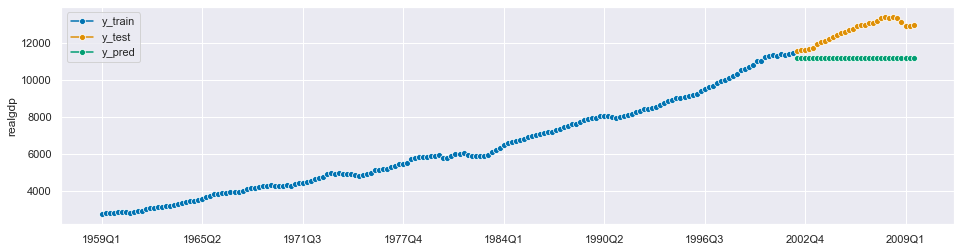

In [59]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

## 4. New forecasting functionalities

### Transformers

In [60]:
from sktime.transformations.series.detrend import Detrender, Deseasonalizer
from sktime.transformations.series.boxcox import BoxCoxTransformer

In [61]:
transformer = Detrender() # linear detrending
transformer.fit(y_train)
y_train_transformed = transformer.transform(y_train)

In [62]:
transformer = Deseasonalizer(sp=4) #removing seasonality
y_train_transformed = transformer.fit_transform(y_train)

In [63]:
y_train_inversed = transformer.inverse_transform(y_train_transformed) #inversing the seasonality removal

In [64]:
(np.round(y_train.values, 3) == np.round(y_train_inversed.values, 3)).all()

True

In [65]:
forecaster = ThetaForecaster(sp=4)
transformer = BoxCoxTransformer(sp=4) #Box-Cox power transformation
y_train_transformed = transformer.fit_transform(y_train)

In [66]:
forecaster.fit(y_train_transformed)
y_pred = forecaster.predict(fh=fh_abs)
y_pred_inversed = transformer.inverse_transform(y_pred)

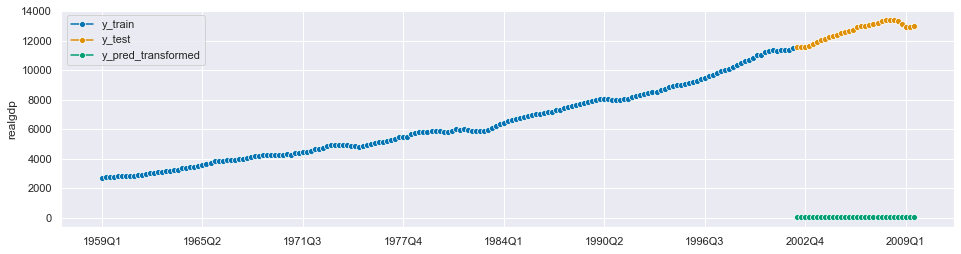

In [67]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred_transformed"]);

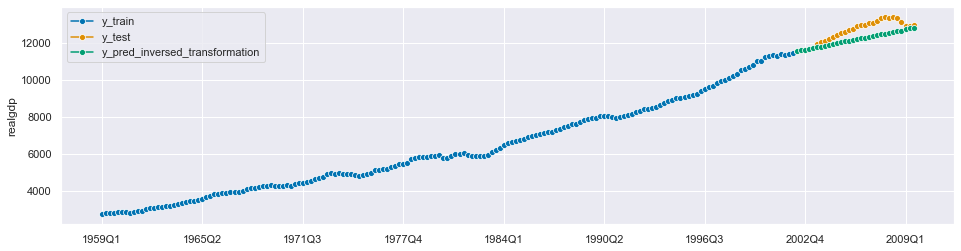

In [68]:
plot_series(y_train, y_test, y_pred_inversed, labels=["y_train", "y_test", "y_pred_inversed_transformation"]);

### Pipelines

- **Simple pipeline**

In [69]:
from sktime.forecasting.compose import TransformedTargetForecaster

In [70]:
forecaster = TransformedTargetForecaster(
    [("deseasonalize", Deseasonalizer(sp=4)),
    ("box_cox", BoxCoxTransformer(sp=4)),    
    ("forecast", ThetaForecaster(sp=4))]
)

In [71]:
forecaster.fit(y_train)
y_pred = forecaster.predict(fh_abs)

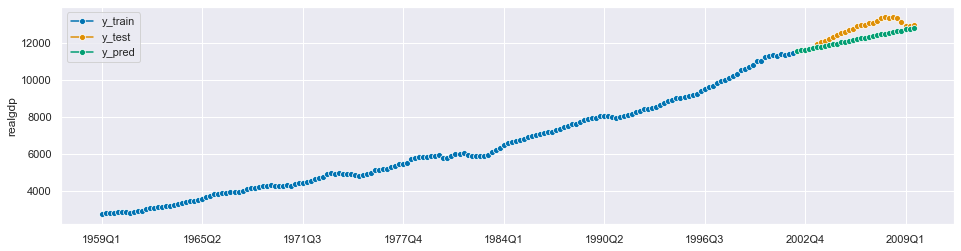

In [72]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

- **Pipeline with exogenous data**

In [73]:
from sktime.forecasting.compose import ForecastingPipeline
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.outlier_detection import HampelFilter

In [74]:
forecaster = ForecastingPipeline(
    [("hampel", HampelFilter()),
    ("log", LogTransformer()),
    ("forecaster", ThetaForecaster(sp=4))])

In [75]:
forecaster.fit(y_train, X_train)
y_pred = forecaster.predict(fh=fh_abs, X=X_test)

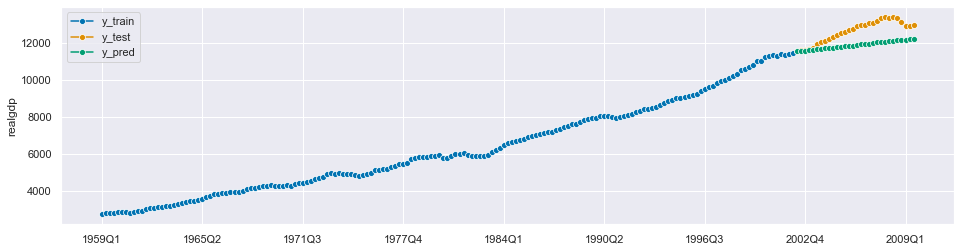

In [76]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

### AutoML

- *****MultiplexForecaster***** - **finding the best forecaster** 

In [77]:
from sktime.forecasting.compose import MultiplexForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS

In [78]:
forecaster = MultiplexForecaster(
    forecasters=[
        ("theta", ThetaForecaster(sp=4)),
        ("ets", ExponentialSmoothing(trend="add", sp=4)),
        ('aets', AutoETS(sp=4)),
        ('autoarima', AutoARIMA(sp=4)),
    ],
)

In [79]:
cv = ExpandingWindowSplitter(initial_window=int(len(y_train) * 0.8))
forecaster_param_grid = {"selected_forecaster": ["theta", "ets", 'aets' , "autoarima"]}
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=forecaster_param_grid)

In [80]:
gscv.fit(y_train)

ForecastingGridSearchCV(cv=ExpandingWindowSplitter(initial_window=None),
                        forecaster=MultiplexForecaster(forecasters=[('theta',
                                                                     ThetaForecaster(sp=4)),
                                                                    ('ets',
                                                                     ExponentialSmoothing(sp=4,
                                                                                          trend='add')),
                                                                    ('aets',
                                                                     AutoETS(sp=4)),
                                                                    ('autoarima',
                                                                     AutoARIMA(sp=4))]),
                        param_grid={'selected_forecaster': ['theta', 'ets',
                                                            'aets',
  

In [81]:
gscv.best_params_

{'selected_forecaster': 'ets'}

In [82]:
gscv.best_forecaster_

MultiplexForecaster(forecasters=[('theta', ThetaForecaster(sp=4)),
                                 ('ets',
                                  ExponentialSmoothing(sp=4, trend='add')),
                                 ('aets', AutoETS(sp=4)),
                                 ('autoarima', AutoARIMA(sp=4))],
                    selected_forecaster='ets')

- *****OptionalPassthrough***** - **finding best transformations** 

In [83]:
from sktime.transformations.series.compose import OptionalPassthrough

In [84]:
forecaster = TransformedTargetForecaster([
("deseasonalizer", OptionalPassthrough(Deseasonalizer())),
("forecaster", ExponentialSmoothing())])

In [85]:
cv = ExpandingWindowSplitter(initial_window=int(len(y_train) * 0.8))

In [86]:
forecaster.get_params()

{'steps': [('deseasonalizer',
   OptionalPassthrough(transformer=Deseasonalizer())),
  ('forecaster', ExponentialSmoothing())],
 'deseasonalizer': OptionalPassthrough(transformer=Deseasonalizer()),
 'forecaster': ExponentialSmoothing(),
 'deseasonalizer__passthrough': False,
 'deseasonalizer__transformer__model': 'additive',
 'deseasonalizer__transformer__sp': 1,
 'deseasonalizer__transformer': Deseasonalizer(),
 'forecaster__damped_trend': False,
 'forecaster__initial_level': None,
 'forecaster__initial_seasonal': None,
 'forecaster__initial_trend': None,
 'forecaster__initialization_method': 'estimated',
 'forecaster__seasonal': None,
 'forecaster__sp': None,
 'forecaster__trend': None,
 'forecaster__use_boxcox': None}

In [87]:
param_grid = {
"deseasonalizer__passthrough" : [True, False],
'deseasonalizer__transformer__model': ['additive', 'multiplicative'],
"forecaster__trend": ["additive", 'multiplicative']}

In [88]:
gscv = ForecastingGridSearchCV(
forecaster=forecaster,
param_grid=param_grid,
cv=cv)

In [89]:
gscv.fit(y_train)

ForecastingGridSearchCV(cv=ExpandingWindowSplitter(initial_window=None),
                        forecaster=TransformedTargetForecaster(steps=[('deseasonalizer',
                                                                       OptionalPassthrough(transformer=Deseasonalizer())),
                                                                      ('forecaster',
                                                                       ExponentialSmoothing())]),
                        param_grid={'deseasonalizer__passthrough': [True,
                                                                    False],
                                    'deseasonalizer__transformer__model': ['additive',
                                                                           'multiplicative'],
                                    'forecaster__trend': ['additive',
                                                          'multiplicative']})

In [90]:
gscv.best_params_

{'deseasonalizer__passthrough': True,
 'deseasonalizer__transformer__model': 'additive',
 'forecaster__trend': 'multiplicative'}

In [91]:
gscv.best_score_

0.004180917222221059

### Ensemble forecasting

In [98]:
from sktime.forecasting.compose import EnsembleForecaster
from sktime.forecasting.tbats import TBATS

In [99]:
ensemble = EnsembleForecaster(forecasters = [("tbats", TBATS()),
    ("arima", AutoARIMA())],                         
     aggfunc = 'min')

In [100]:
ensemble.fit(y_train)

EnsembleForecaster(aggfunc='min',
                   forecasters=[('tbats', TBATS()), ('arima', AutoARIMA())])

In [101]:
ensemble.forecasters_

[TBATS(), AutoARIMA()]

In [102]:
y_pred = ensemble.predict(fh_abs)

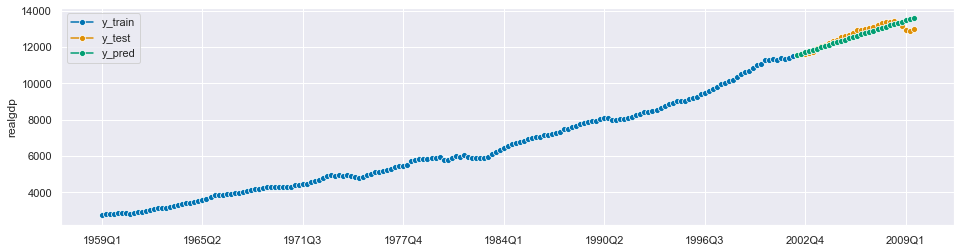

In [103]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);